In [1]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import concatenate
from sklearn.metrics import accuracy_score
from sklearn import decomposition
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
import math
import mahotas
from ssGMM import MultinomialNBSS
from skimage.feature import daisy
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage import feature
from itertools import combinations

In [2]:
color_layout_features  = pd.read_pickle("color_layout_descriptor_64.pkl")
bow_surf  = pd.read_pickle("bow_surf_64.pkl")
color_hist_features  = pd.read_pickle("hist_64.pkl")
labels  = pd.read_pickle("labels_64.pkl")
data  = pd.read_pickle("data_64.pkl")



def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 


color_layout_features_scaled = scale(color_layout_features, 0, 1)


def hogs(img):
    _, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    return hog_image

def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick



def extract_daisy(img,daisy_step_size=32,daisy_radius=32):
    img_gray = rgb2gray(img)
    descs = daisy(img_gray, step=8, radius=8, rings=2, histograms=8,orientations=8, visualize=False)
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_desriptors=descs.reshape(descs_num,descs.shape[2])
    return daisy_desriptors.reshape(-1)




class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
    
    
desc = LocalBinaryPatterns(24, 8)
hist = [desc.describe(data[i]) for i in range(len(data))]
hist = np.array(hist)

# hog_features = [hogs(data[i]) for i in range(len(data))]
# hog_features = np.array(hog_features)
# hog_features = hog_features.reshape(hog_features.shape[0],-1)

# daisy_fea = [extract_daisy(data[i]) for i in range(len(data))]
# hog_features = scale(hog_features, 0, 1)


indcs = np.array([i for i in range(len(data))]).reshape(-1,1)
features = np.hstack([color_layout_features_scaled,bow_surf,color_hist_features, np.array(hist)])
features.shape


features = features.astype('float64')

In [3]:
"""
exp feature includinh hog
"""

exp_features = features #np.exp(features)

tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
tot_features[:,:-1] = exp_features
tot_features[:,-1] = labels
tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

feat = tot_features[:,:-1].astype("float64")
lab = tot_features[:,-1].astype("uint8")

fs = SelectKBest(score_func=f_classif, k=500)
fs.fit(feat, lab)
selected_features = fs.transform(feat)

data_lable = labels

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []


for i in list(range(9, 0, -1)):
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(selected_features, lab, test_size=i/10, random_state=1, stratify=data_lable)

    print("Labeled features set Size: %d, %d"%X_train_lab.shape)
    print("Labeled lable set Size: %d"%y_train_lab.shape)
    print("UnLabled features set Size: %d, %d"%X_test_unlab.shape)
    print("UnLabled lable set Size: %d"%y_test_unlab.shape)
    print("")
        


    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)

    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed)
    print("Dataset accuracy: %f for %f of unlabled dataset"% (accuracy_score(y_train_mixed, yhat), i*10))
    total_data_acc.append(accuracy_score(y_train_mixed, yhat))

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    print("Unlabled Dataset Accuracy: %f for %f of unlabled dataset"% (accuracy_score(y_test_unlab, yhat), i*10))
    unlabeled_data_acc.append(accuracy_score(y_test_unlab, yhat))
    
    yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
    print("Labled Dataset Accurcy: %f for %f of unlabled dataset"% (accuracy_score(y_train_lab, yhat), i*10))
    labeled_data_acc.append(accuracy_score(y_train_lab, yhat))

    split_ratio.append(i)

Labeled features set Size: 1556, 500
Labeled lable set Size: 1556
UnLabled features set Size: 14006, 500
UnLabled lable set Size: 14006

Dataset accuracy: 0.032194 for 90.000000 of unlabled dataset
Unlabled Dataset Accuracy: 0.310224 for 90.000000 of unlabled dataset
Labled Dataset Accurcy: 0.321979 for 90.000000 of unlabled dataset
Labeled features set Size: 3112, 500
Labeled lable set Size: 3112
UnLabled features set Size: 12450, 500
UnLabled lable set Size: 12450

Dataset accuracy: 0.064002 for 80.000000 of unlabled dataset
Unlabled Dataset Accuracy: 0.319759 for 80.000000 of unlabled dataset
Labled Dataset Accurcy: 0.320051 for 80.000000 of unlabled dataset
Labeled features set Size: 4668, 500
Labeled lable set Size: 4668
UnLabled features set Size: 10894, 500
UnLabled lable set Size: 10894

Dataset accuracy: 0.099859 for 70.000000 of unlabled dataset
Unlabled Dataset Accuracy: 0.329447 for 70.000000 of unlabled dataset
Labled Dataset Accurcy: 0.332905 for 70.000000 of unlabled dat

<AxesSubplot:xlabel='Unlabeled Dataset Size %', ylabel='Unlabeled Dataset Accuracy'>

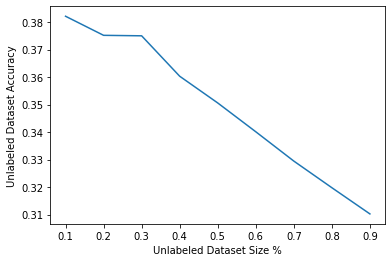

In [4]:
import seaborn as sns

df = pd.DataFrame()
df['Unlabeled Dataset Size %'] = split_ratio
df['Unlabeled Dataset Size %'] = df['Unlabeled Dataset Size %']/10
df['Unlabeled Dataset Accuracy'] = unlabeled_data_acc
sns.lineplot(data=df, x="Unlabeled Dataset Size %", y="Unlabeled Dataset Accuracy")

# Differerent Feature Combinations

In [5]:
## checking combination of the features

"""
1 feature combination
"""

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 1)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]]])
        
        exp_features = temp_feat

        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")
        

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

Labeled features set Size: 1556, 192
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 192
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.034828 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.348565 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.348329 for 90.000000 of Unlabled dataset
Labeled features set Size: 1556, 384
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 384
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 1 index 0.032194 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 1 index 0.306654 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 1 index 0.321979 for 90.000000 of Unlabled dataset
Labeled features set Size: 1556, 128
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 128
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 2 index 0.034828 for 90.000000 of U

Labeled features set Size: 9337, 384
Labeled lable set Size: 9337
Unlabeled features set Size: 6225, 384
Unlabeled lable set Size: 6225

Dataset Accuracy: for feature 1 index 0.213854 for 40.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 1 index 0.347309 for 40.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 1 index 0.356431 for 40.000000 of Unlabled dataset
Labeled features set Size: 9337, 128
Labeled lable set Size: 9337
Unlabeled features set Size: 6225, 128
Unlabeled lable set Size: 6225

Dataset Accuracy: for feature 2 index 0.209099 for 40.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 2 index 0.348594 for 40.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 2 index 0.348506 for 40.000000 of Unlabled dataset
Labeled features set Size: 9337, 26
Labeled lable set Size: 9337
Unlabeled features set Size: 6225, 26
Unlabeled lable set Size: 6225

Dataset Accuracy: for feature 3 index 0.209099 for 40.000000 of Unlabled 

In [6]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]

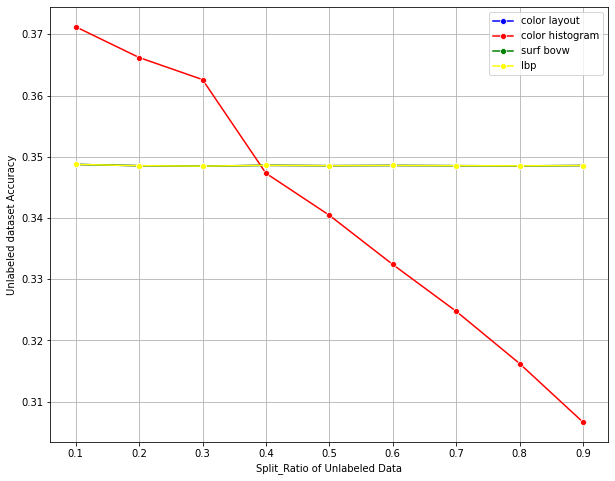

In [7]:
import seaborn as sns
f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color histogram", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled dataset Accuracy')
plt.show()

In [8]:
"""
combination of 2 features
"""

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 2)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]]])
        
        exp_features = temp_feat#np.exp(temp_feat)

        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")
        

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

Labeled features set Size: 1556, 576
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 576
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.031744 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.310153 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.317481 for 90.000000 of Unlabled dataset
Labeled features set Size: 1556, 320
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 320
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.034828 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.348565 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.348329 for 90.000000 of Unlabled dataset
Labeled features set Size: 1556, 218
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 218
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.034828 for 90.000000 of U

Labeled features set Size: 6224, 512
Labeled lable set Size: 6224
Unlabeled features set Size: 9338, 512
Unlabeled lable set Size: 9338

Dataset Accuracy: for feature 1 index 0.136808 for 60.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 1 index 0.334119 for 60.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 1 index 0.342063 for 60.000000 of Unlabled dataset
Labeled features set Size: 6224, 410
Labeled lable set Size: 6224
Unlabeled features set Size: 9338, 410
Unlabeled lable set Size: 9338

Dataset Accuracy: for feature 1 index 0.134880 for 60.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 1 index 0.333262 for 60.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 1 index 0.337243 for 60.000000 of Unlabled dataset
Labeled features set Size: 6224, 154
Labeled lable set Size: 6224
Unlabeled features set Size: 9338, 154
Unlabeled lable set Size: 9338

Dataset Accuracy: for feature 2 index 0.139378 for 60.000000 of Unlable

Labeled features set Size: 12449, 576
Labeled lable set Size: 12449
Unlabeled features set Size: 3113, 576
Unlabeled lable set Size: 3113

Dataset Accuracy: for feature 0 index 0.301696 for 20.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.370061 for 20.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.377139 for 20.000000 of Unlabled dataset
Labeled features set Size: 12449, 320
Labeled lable set Size: 12449
Unlabeled features set Size: 3113, 320
Unlabeled lable set Size: 3113

Dataset Accuracy: for feature 0 index 0.278820 for 20.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.348538 for 20.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.348542 for 20.000000 of Unlabled dataset
Labeled features set Size: 12449, 218
Labeled lable set Size: 12449
Unlabeled features set Size: 3113, 218
Unlabeled lable set Size: 3113

Dataset Accuracy: for feature 0 index 0.278820 for 20.000000 of U

In [9]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []

fifth_feature_splits = []
fifth_feat_acc = []
fifth_feature_lab_acc = []
fifth_feature_unlab_acc = []

sixth_feature_splits = []
sixth_feat_acc = []
sixth_feature_lab_acc = []
sixth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    fifth_feature_splits.append(split_ratio[i][4])
    fifth_feat_acc.append(total_data_acc[i][4])
    fifth_feature_lab_acc.append(labeled_data_acc[i][4])
    fifth_feature_unlab_acc.append(unlabeled_data_acc[i][4])
    
    sixth_feature_splits.append(split_ratio[i][5])
    sixth_feat_acc.append(total_data_acc[i][5])
    sixth_feature_lab_acc.append(labeled_data_acc[i][5])
    sixth_feature_unlab_acc.append(unlabeled_data_acc[i][5])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]
fifth_feature_splits = [i/10 for i in fifth_feature_splits]
sixth_feature_splits = [i/10 for i in sixth_feature_splits]

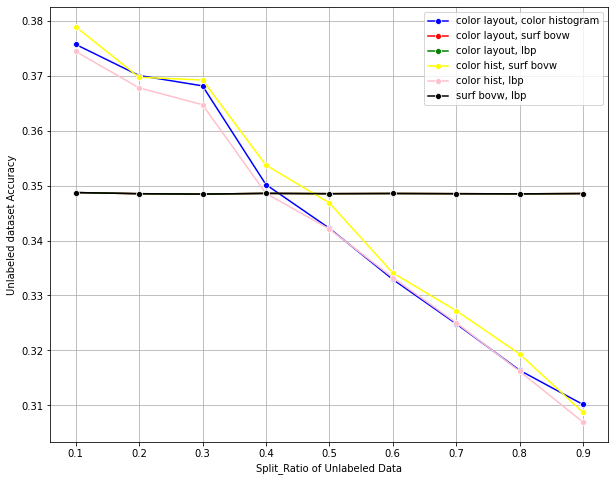

In [10]:
f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color layout, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="color layout, lbp", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="color hist, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =fifth_feature_splits, y= fifth_feature_unlab_acc, color="pink", marker="o", label="color hist, lbp", linestyle="-")
sns.lineplot(ax=ax, x =sixth_feature_splits, y= sixth_feature_unlab_acc, color="black", marker="o", label="surf bovw, lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled dataset Accuracy')
plt.show()

In [11]:
"""
3 feature combination
"""

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 3)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]], feat_list[feat_indx[2]]])
        
        exp_features = temp_feat#np.exp(temp_feat)

        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")
        

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

Labeled features set Size: 1556, 704
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 704
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.032644 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.325146 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.326478 for 90.000000 of Unlabled dataset
Labeled features set Size: 1556, 602
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 602
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.031551 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.314080 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.315553 for 90.000000 of Unlabled dataset
Labeled features set Size: 1556, 346
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 346
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.034828 for 90.000000 of U

Labeled features set Size: 9337, 602
Labeled lable set Size: 9337
Unlabeled features set Size: 6225, 602
Unlabeled lable set Size: 6225

Dataset Accuracy: for feature 0 index 0.215332 for 40.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.350683 for 40.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.358895 for 40.000000 of Unlabled dataset
Labeled features set Size: 9337, 346
Labeled lable set Size: 9337
Unlabeled features set Size: 6225, 346
Unlabeled lable set Size: 6225

Dataset Accuracy: for feature 0 index 0.209099 for 40.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.348594 for 40.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.348506 for 40.000000 of Unlabled dataset
Labeled features set Size: 9337, 538
Labeled lable set Size: 9337
Unlabeled features set Size: 6225, 538
Unlabeled lable set Size: 6225

Dataset Accuracy: for feature 1 index 0.219959 for 40.000000 of Unlable

In [12]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]

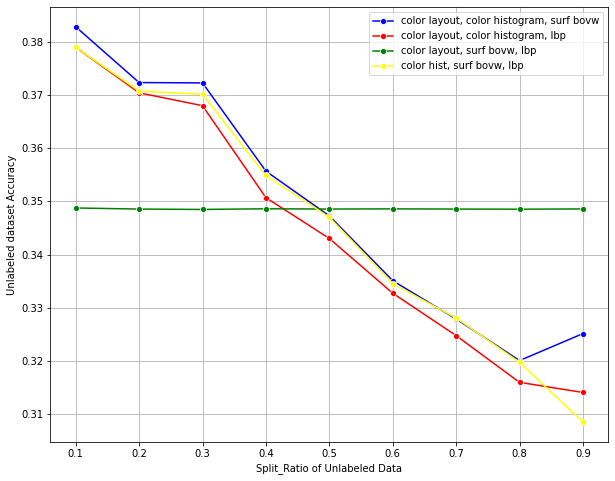

In [13]:
f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color layout, color histogram, lbp", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="color layout, surf bovw, lbp", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="color hist, surf bovw, lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled dataset Accuracy')
plt.show()

In [14]:
"""
4 feature combination
"""

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 4)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]], feat_list[feat_indx[0]]])
        
        exp_features = temp_feat#np.exp(temp_feat)

        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")
        

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labled Dataset Accuracy: for feature %d index %f for %f of Unlabled dataset"% (feat_indx[0], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

Labeled features set Size: 1556, 768
Labeled lable set Size: 1556
Unlabeled features set Size: 14006, 768
Unlabeled lable set Size: 14006

Dataset Accuracy: for feature 0 index 0.031680 for 90.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.311652 for 90.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.316838 for 90.000000 of Unlabled dataset
Labeled features set Size: 3112, 768
Labeled lable set Size: 3112
Unlabeled features set Size: 12450, 768
Unlabeled lable set Size: 12450

Dataset Accuracy: for feature 0 index 0.062974 for 80.000000 of Unlabled dataset
Unlabled Dataset Accuracy: for feature 0 index 0.317430 for 80.000000 of Unlabled dataset
Labled Dataset Accuracy: for feature 0 index 0.314910 for 80.000000 of Unlabled dataset
Labeled features set Size: 4668, 768
Labeled lable set Size: 4668
Unlabeled features set Size: 10894, 768
Unlabeled lable set Size: 10894

Dataset Accuracy: for feature 0 index 0.097931 for 70.000000 of U

In [15]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]

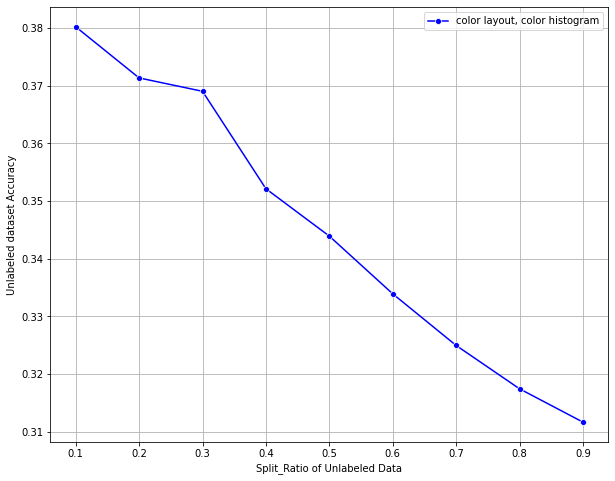

In [16]:
f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram", linestyle="-")
ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled dataset Accuracy')
plt.show()

In [17]:
"""
based on the above curve chooising the most important features
"""

features = np.hstack([color_hist_features, bow_surf])
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, data_lable, test_size=0.3, random_state=1, stratify=data_lable)

print("Labeled features set Size: %d, %d"%X_train_lab.shape)
print("Labeled lable set Size: %d"%y_train_lab.shape)
print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
print("")


X_train_mixed = concatenate((X_train_lab, X_test_unlab))
nolabel = [-1 for _ in range(len(y_test_unlab))]
y_train_mixed = concatenate((y_train_lab, nolabel))

model = MultinomialNBSS(verbose=False)

model.fit(X_train_mixed, y_train_mixed)

yhat = model.predict(X_train_mixed)
i = 0
print("Dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_train_mixed, yhat), i*10))

yhat = model.predict(X_train_mixed[y_train_mixed==-1])
print("Unlabeled Dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_test_unlab, yhat), i*10))

yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
print("Labeled Dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_train_lab, yhat), i*10))

Labeled features set Size: 10893, 640
Labeled lable set Size: 10893
Unlabeled features set Size: 4669, 640
Unlabeled lable set Size: 4669

Dataset Accuracy: 0.261920 for 0.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: 0.371600 for 0.000000 of Unlabeled dataset
Labeled Dataset Accuracy: 0.374185 for 0.000000 of Unlabeled dataset


In [18]:
yhat = model.predict(X_train_mixed[y_train_mixed==-1])
conf_matrix = confusion_matrix(y_test_unlab, yhat)

<AxesSubplot:>

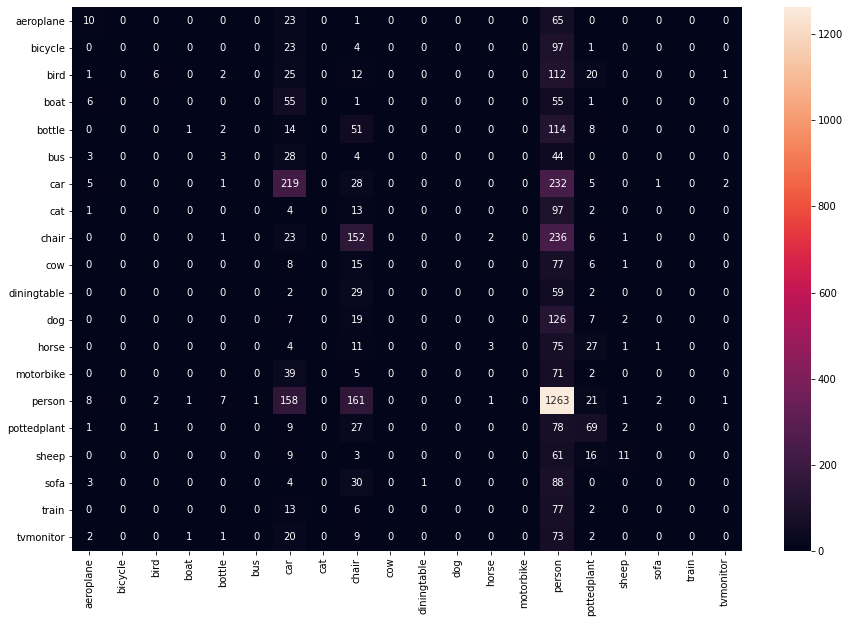

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classs = ['aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

df_cm = pd.DataFrame(conf_matrix, index = [i for i in classs],
                  columns = [i for i in classs])
df_cm = df_cm.astype(int)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt="d")

In [20]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

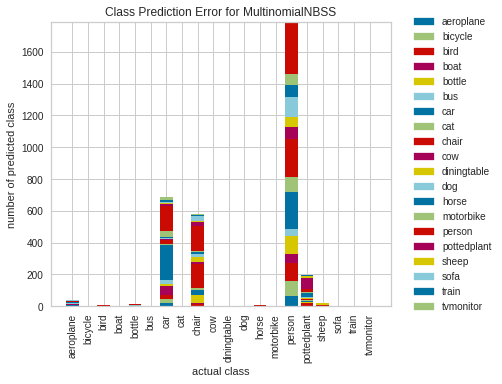

<AxesSubplot:title={'center':'Class Prediction Error for MultinomialNBSS'}, xlabel='actual class', ylabel='number of predicted class'>

In [21]:
visualizer = ClassPredictionError(MultinomialNBSS(verbose=False), classes=classs)
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

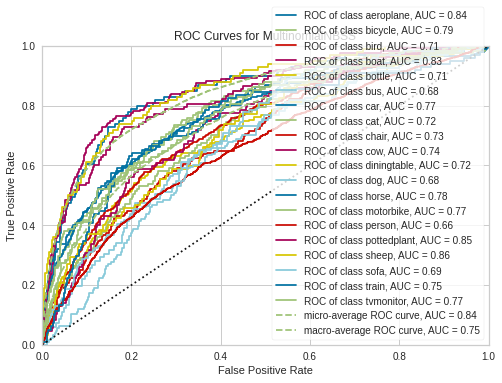

<AxesSubplot:title={'center':'ROC Curves for MultinomialNBSS'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [22]:
visualizer = ROCAUC(MultinomialNBSS(verbose=False), classes=classs)
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


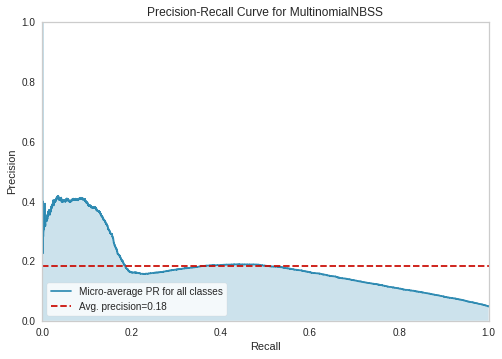

<AxesSubplot:title={'center':'Precision-Recall Curve for MultinomialNBSS'}, xlabel='Recall', ylabel='Precision'>

In [23]:
visualizer = PrecisionRecallCurve(MultinomialNBSS(verbose=False))
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

In [24]:
#Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef

# Class Balancing

In [25]:
"""
Model running by class balancing
"""

features = np.hstack([color_hist_features, bow_surf])
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, labels, test_size=0.3, random_state=1, stratify=labels)

print("Labeled features set Size: %d, %d"%X_train_lab.shape)
print("Labeled lable set Size: %d"%y_train_lab.shape)
print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
print("Unlabeled label set Size: %d"%y_test_unlab.shape)


for i in np.unique(labels):
    print("Number of Records for Class %d is: %d"%(i, len(np.where(y_train_lab==i)[0])))

Labeled features set Size: 10893, 640
Labeled lable set Size: 10893
Unlabeled features set Size: 4669, 640
Unlabeled label set Size: 4669
Number of Records for Class 0 is: 232
Number of Records for Class 1 is: 292
Number of Records for Class 2 is: 419
Number of Records for Class 3 is: 276
Number of Records for Class 4 is: 443
Number of Records for Class 5 is: 190
Number of Records for Class 6 is: 1150
Number of Records for Class 7 is: 272
Number of Records for Class 8 is: 983
Number of Records for Class 9 is: 248
Number of Records for Class 10 is: 216
Number of Records for Class 11 is: 376
Number of Records for Class 12 is: 283
Number of Records for Class 13 is: 272
Number of Records for Class 14 is: 3797
Number of Records for Class 15 is: 437
Number of Records for Class 16 is: 233
Number of Records for Class 17 is: 295
Number of Records for Class 18 is: 228
Number of Records for Class 19 is: 251


In [26]:
class1, lab1 =  X_train_lab[y_train_lab==1], y_train_lab[y_train_lab==1]
class2, lab2 =  X_train_lab[y_train_lab==2], y_train_lab[y_train_lab==2]
class3, lab3 =  X_train_lab[y_train_lab==3], y_train_lab[y_train_lab==3]
class4, lab4 =  X_train_lab[y_train_lab==4], y_train_lab[y_train_lab==4]
class5, lab5 =  X_train_lab[y_train_lab==5], y_train_lab[y_train_lab==5]
class6, lab6 =  X_train_lab[y_train_lab==6], y_train_lab[y_train_lab==6]
class7, lab7 =  X_train_lab[y_train_lab==7], y_train_lab[y_train_lab==7]
class8, lab8 =  X_train_lab[y_train_lab==8], y_train_lab[y_train_lab==8]
class9, lab9 =  X_train_lab[y_train_lab==9], y_train_lab[y_train_lab==9]
class10, lab10 =  X_train_lab[y_train_lab==10], y_train_lab[y_train_lab==10]
class11, lab11 =  X_train_lab[y_train_lab==11], y_train_lab[y_train_lab==11]
class12, lab12 =  X_train_lab[y_train_lab==12], y_train_lab[y_train_lab==12]
class13, lab13 =  X_train_lab[y_train_lab==13], y_train_lab[y_train_lab==13]
class14, lab14 =  X_train_lab[y_train_lab==14], y_train_lab[y_train_lab==14]
class15, lab15 =  X_train_lab[y_train_lab==15], y_train_lab[y_train_lab==15]
class16, lab16 =  X_train_lab[y_train_lab==16], y_train_lab[y_train_lab==16]
class17, lab17 =  X_train_lab[y_train_lab==17], y_train_lab[y_train_lab==17]
class18, lab18 =  X_train_lab[y_train_lab==18], y_train_lab[y_train_lab==18]
class19, lab19 =  X_train_lab[y_train_lab==19], y_train_lab[y_train_lab==19]
class0, lab0 =  X_train_lab[y_train_lab==0], y_train_lab[y_train_lab==0]

class14 = class14[:100]
lab14 = lab14[:100]

class6 = class6[:100]
lab6 = lab6[:100]

class8 = class8[:100]
lab8 = lab8[:100]

X_train_lab = concatenate((class1, class2, class3, class4, class5, class7, class9, 
             class10, class11, class12, class13, class15, class16, class17, class18, 
             class19, class0))

y_train_lab = concatenate((lab1, lab2, lab3, lab4, lab5, lab7, lab9, 
             lab10, lab11, lab12, lab13, lab15, lab16, lab17, lab18, 
             lab19, lab0))

In [27]:
class1, lab1 =  X_test_unlab[y_test_unlab==1], y_test_unlab[y_test_unlab==1]
class2, lab2 =  X_test_unlab[y_test_unlab==2], y_test_unlab[y_test_unlab==2]
class3, lab3 =  X_test_unlab[y_test_unlab==3], y_test_unlab[y_test_unlab==3]
class4, lab4 =  X_test_unlab[y_test_unlab==4], y_test_unlab[y_test_unlab==4]
class5, lab5 =  X_test_unlab[y_test_unlab==5], y_test_unlab[y_test_unlab==5]
class6, lab6 =  X_test_unlab[y_test_unlab==6], y_test_unlab[y_test_unlab==6]
class7, lab7 =  X_test_unlab[y_test_unlab==7], y_test_unlab[y_test_unlab==7]
class8, lab8 =  X_test_unlab[y_test_unlab==8], y_test_unlab[y_test_unlab==8]
class9, lab9 =  X_test_unlab[y_test_unlab==9], y_test_unlab[y_test_unlab==9]
class10, lab10 =  X_test_unlab[y_test_unlab==10], y_test_unlab[y_test_unlab==10]
class11, lab11 =  X_test_unlab[y_test_unlab==11], y_test_unlab[y_test_unlab==11]
class12, lab12 =  X_test_unlab[y_test_unlab==12], y_test_unlab[y_test_unlab==12]
class13, lab13 =  X_test_unlab[y_test_unlab==13], y_test_unlab[y_test_unlab==13]
class14, lab14 =  X_test_unlab[y_test_unlab==14], y_test_unlab[y_test_unlab==14]
class15, lab15 =  X_test_unlab[y_test_unlab==15], y_test_unlab[y_test_unlab==15]
class16, lab16 =  X_test_unlab[y_test_unlab==16], y_test_unlab[y_test_unlab==16]
class17, lab17 =  X_test_unlab[y_test_unlab==17], y_test_unlab[y_test_unlab==17]
class18, lab18 =  X_test_unlab[y_test_unlab==18], y_test_unlab[y_test_unlab==18]
class19, lab19 =  X_test_unlab[y_test_unlab==19], y_test_unlab[y_test_unlab==19]
class0, lab0 =  X_test_unlab[y_test_unlab==0], y_test_unlab[y_test_unlab==0]


X_test_unlab = concatenate((class1, class2, class3, class4, class5, class7, class9, 
             class10, class11, class12, class13, class15, class16, class17, class18, 
             class19, class0))

y_test_unlab = concatenate((lab1, lab2, lab3, lab4, lab5, lab7, lab9, 
             lab10, lab11, lab12, lab13, lab15, lab16, lab17, lab18, 
             lab19, lab0))

In [28]:
y_train_lab[y_train_lab==7] = 6
y_train_lab[y_train_lab==9] = 7
y_train_lab[y_train_lab==10] = 8
y_train_lab[y_train_lab==11] = 9
y_train_lab[y_train_lab==12] = 10
y_train_lab[y_train_lab==13] = 11
y_train_lab[y_train_lab==15] = 12
y_train_lab[y_train_lab==16] = 13
y_train_lab[y_train_lab==17] = 14
y_train_lab[y_train_lab==18] = 15
y_train_lab[y_train_lab==19] = 16

y_test_unlab[y_test_unlab==7] = 6
y_test_unlab[y_test_unlab==9] = 7
y_test_unlab[y_test_unlab==10] = 8
y_test_unlab[y_test_unlab==11] = 9
y_test_unlab[y_test_unlab==12] = 10
y_test_unlab[y_test_unlab==13] = 11
y_test_unlab[y_test_unlab==15] = 12
y_test_unlab[y_test_unlab==16] = 13
y_test_unlab[y_test_unlab==17] = 14
y_test_unlab[y_test_unlab==18] = 15
y_test_unlab[y_test_unlab==19] = 16

In [29]:
X_train_mixed = concatenate((X_train_lab, X_test_unlab))
nolabel = [-1 for _ in range(len(y_test_unlab))]
y_train_mixed = concatenate((y_train_lab, nolabel))

model = MultinomialNBSS(verbose=False)

model.fit(X_train_mixed, y_train_mixed)

yhat = model.predict(X_train_mixed)
i = 0
print("Dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_train_mixed, yhat), i*10))

yhat = model.predict(X_train_mixed[y_train_mixed==-1])
print("Unlabeled dataset accurcy: %f for %f of Unlabeled dataset"% (accuracy_score(y_test_unlab, yhat), i*10))

yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
print("Labeled dataset accurcy: %f for %f of Unlabeled dataset"% (accuracy_score(y_train_lab, yhat), i*10))

Dataset Accuracy: 0.180087 for 0.000000 of Unlabeled dataset
Unlabeled dataset accurcy: 0.240132 for 0.000000 of Unlabeled dataset
Labeled dataset accurcy: 0.257304 for 0.000000 of Unlabeled dataset


<AxesSubplot:>

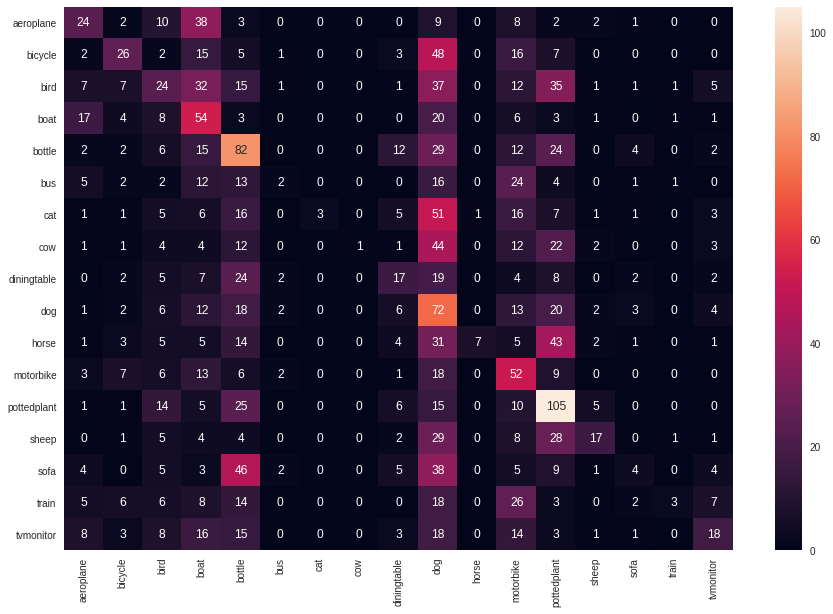

In [30]:
yhat = model.predict(X_train_mixed[y_train_mixed==-1])
conf_matrix = confusion_matrix(y_test_unlab, yhat)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classs = ['aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'cat',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

df_cm = pd.DataFrame(conf_matrix, index = [i for i in classs],
                  columns = [i for i in classs])
df_cm = df_cm.astype(int)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt="d")

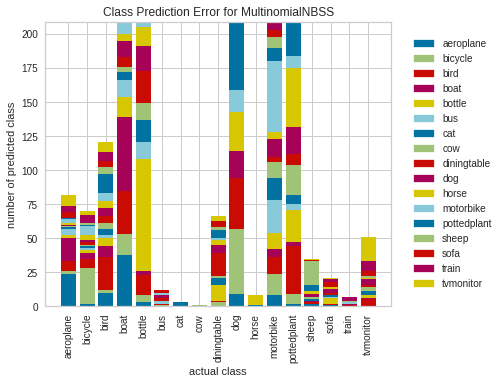

<AxesSubplot:title={'center':'Class Prediction Error for MultinomialNBSS'}, xlabel='actual class', ylabel='number of predicted class'>

In [31]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

classs = ['aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'cat',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']

visualizer = ClassPredictionError(MultinomialNBSS(verbose=False), classes=classs)
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

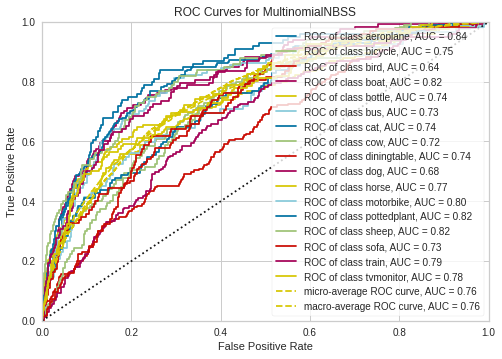

<AxesSubplot:title={'center':'ROC Curves for MultinomialNBSS'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [32]:
visualizer = ROCAUC(MultinomialNBSS(verbose=False), classes=classs)
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


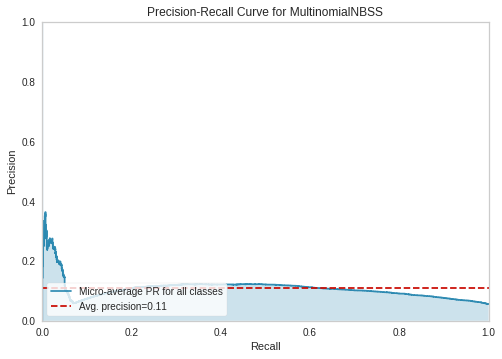

<AxesSubplot:title={'center':'Precision-Recall Curve for MultinomialNBSS'}, xlabel='Recall', ylabel='Precision'>

In [33]:
visualizer = PrecisionRecallCurve(MultinomialNBSS(verbose=False))
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

# Class Balancing with Feature Selection using Anova

In [34]:
labels_orig = labels

In [35]:
from imblearn.under_sampling import RandomUnderSampler

In [36]:
"""
Combination of 2 Features
"""

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

undersample = RandomUnderSampler(random_state=123)
fs = SelectKBest(score_func=f_classif, k=100)

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 2)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]]])
        fs.fit(temp_feat, labels_orig)
        temp_feat = fs.transform(temp_feat)
        
        exp_features, labels = undersample.fit_resample(temp_feat, labels_orig)
        
        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")
        
        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabeled Dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("labled Dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 544, 100
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 100
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 1) index 0.013235 for 90.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.109477 for 90.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.132353 for 90.000000 of Unlabeled dataset
Labeled features set Size: 544, 100
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 100
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 2) index 0.022610 for 90.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.100694 for 90.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.226103 for 90.000000 of Unlabeled dataset
Labeled features set Size: 544, 100
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 100
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 3) in

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 544, 100
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 100
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (1, 2) index 0.012500 for 90.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.098448 for 90.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.125000 for 90.000000 of Unlabeled dataset
Labeled features set Size: 544, 100
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 100
Unlabeled lable set Size: 4896



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 3) index 0.011397 for 90.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.097631 for 90.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.113971 for 90.000000 of Unlabeled dataset
Labeled features set Size: 544, 100
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 100
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (2, 3) index 0.023897 for 90.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.110498 for 90.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.238971 for 90.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1088, 100
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 100
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (0, 1) index 0.033272 for 80.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.130744 for 80.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.166360 for 80.000000 of Unlabeled dataset
Labeled features set Size: 1088, 100
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 100
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (0, 2) index 0.045037 for 80.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.121783 for 80.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.225184 for 80.000000 of Unlabeled dataset
Labeled features set Size: 1088, 100
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 100
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1088, 100
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 100
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (1, 2) index 0.031434 for 80.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.130515 for 80.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.157169 for 80.000000 of Unlabeled dataset
Labeled features set Size: 1088, 100
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 100
Unlabeled lable set Size: 4352



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 3) index 0.032904 for 80.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.123851 for 80.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.164522 for 80.000000 of Unlabeled dataset
Labeled features set Size: 1088, 100
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 100
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (2, 3) index 0.052757 for 80.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.140165 for 80.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.263787 for 80.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1632, 100
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 100
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (0, 1) index 0.053125 for 70.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.148109 for 70.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.177083 for 70.000000 of Unlabeled dataset
Labeled features set Size: 1632, 100
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 100
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (0, 2) index 0.070956 for 70.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.164128 for 70.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.236520 for 70.000000 of Unlabeled dataset
Labeled features set Size: 1632, 100
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 100
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1632, 100
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 100
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (1, 2) index 0.053125 for 70.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.148634 for 70.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.177083 for 70.000000 of Unlabeled dataset
Labeled features set Size: 1632, 100
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 100
Unlabeled lable set Size: 3808



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 3) index 0.051654 for 70.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.148109 for 70.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.172181 for 70.000000 of Unlabeled dataset
Labeled features set Size: 1632, 100
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 100
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (2, 3) index 0.069853 for 70.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.148897 for 70.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.232843 for 70.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2176, 100
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 100
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0, 1) index 0.071507 for 60.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.154105 for 60.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.178768 for 60.000000 of Unlabeled dataset
Labeled features set Size: 2176, 100
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 100
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0, 2) index 0.100735 for 60.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.189951 for 60.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.251838 for 60.000000 of Unlabeled dataset
Labeled features set Size: 2176, 100
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 100
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2176, 100
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 100
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (1, 2) index 0.075919 for 60.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.164828 for 60.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.189798 for 60.000000 of Unlabeled dataset
Labeled features set Size: 2176, 100
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 100
Unlabeled lable set Size: 3264



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 3) index 0.071507 for 60.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.167279 for 60.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.178768 for 60.000000 of Unlabeled dataset
Labeled features set Size: 2176, 100
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 100
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (2, 3) index 0.091544 for 60.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.154105 for 60.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.228860 for 60.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2720, 100
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 100
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (0, 1) index 0.095037 for 50.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.166912 for 50.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.190074 for 50.000000 of Unlabeled dataset
Labeled features set Size: 2720, 100
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 100
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (0, 2) index 0.123529 for 50.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.187500 for 50.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.247059 for 50.000000 of Unlabeled dataset
Labeled features set Size: 2720, 100
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 100
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2720, 100
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 100
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (1, 2) index 0.096691 for 50.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.164338 for 50.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.193382 for 50.000000 of Unlabeled dataset
Labeled features set Size: 2720, 100
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 100
Unlabeled lable set Size: 2720



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 3) index 0.093934 for 50.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.172059 for 50.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.187868 for 50.000000 of Unlabeled dataset
Labeled features set Size: 2720, 100
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 100
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (2, 3) index 0.109743 for 50.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.154779 for 50.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.219485 for 50.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3264, 100
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 100
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 1) index 0.112316 for 40.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.176471 for 40.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.187194 for 40.000000 of Unlabeled dataset
Labeled features set Size: 3264, 100
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 100
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 2) index 0.152757 for 40.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.200368 for 40.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.254596 for 40.000000 of Unlabeled dataset
Labeled features set Size: 3264, 100
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 100
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3264, 100
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 100
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (1, 2) index 0.117831 for 40.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.178768 for 40.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.196385 for 40.000000 of Unlabeled dataset
Labeled features set Size: 3264, 100
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 100
Unlabeled lable set Size: 2176



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 3) index 0.110846 for 40.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.181985 for 40.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.184743 for 40.000000 of Unlabeled dataset
Labeled features set Size: 3264, 100
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 100
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (2, 3) index 0.127941 for 40.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.161305 for 40.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.213235 for 40.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3808, 100
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 100
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (0, 1) index 0.138603 for 30.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.180760 for 30.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.198004 for 30.000000 of Unlabeled dataset
Labeled features set Size: 3808, 100
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 100
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (0, 2) index 0.176654 for 30.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.200980 for 30.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.252363 for 30.000000 of Unlabeled dataset
Labeled features set Size: 3808, 100
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 100
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3808, 100
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 100
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (1, 2) index 0.137500 for 30.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.171569 for 30.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.196429 for 30.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3808, 100
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 100
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (1, 3) index 0.134007 for 30.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.184436 for 30.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.191439 for 30.000000 of Unlabeled dataset
Labeled features set Size: 3808, 100
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 100
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (2, 3) index 0.143934 for 30.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.157475 for 30.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.205620 for 30.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4352, 100
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 100
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0, 1) index 0.158824 for 20.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.181066 for 20.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.198529 for 20.000000 of Unlabeled dataset
Labeled features set Size: 4352, 100
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 100
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0, 2) index 0.196324 for 20.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.209559 for 20.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.245404 for 20.000000 of Unlabeled dataset
Labeled features set Size: 4352, 100
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 100
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0,

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4352, 100
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 100
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (1, 2) index 0.156801 for 20.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.175551 for 20.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.196002 for 20.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4352, 100
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 100
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (1, 3) index 0.154779 for 20.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.177390 for 20.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.193474 for 20.000000 of Unlabeled dataset
Labeled features set Size: 4352, 100
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 100
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (2, 3) index 0.164522 for 20.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.158088 for 20.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.205653 for 20.000000 of Unlabeled dataset
Labeled features set Size: 4896, 100
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 100
Unlabeled lable set Size: 544



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (0, 1) index 0.185662 for 10.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 1) index 0.181985 for 10.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 1) index 0.206291 for 10.000000 of Unlabeled dataset
Labeled features set Size: 4896, 100
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 100
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (0, 2) index 0.219485 for 10.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 2) index 0.233456 for 10.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (0, 2) index 0.243873 for 10.000000 of Unlabeled dataset
Labeled features set Size: 4896, 100
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 100
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (0, 3) index 0.245037 for 10.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (0, 3) index 0.270221 for 10.000000 of Unlabele

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4896, 100
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 100
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (1, 2) index 0.184191 for 10.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 2) index 0.167279 for 10.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 2) index 0.204657 for 10.000000 of Unlabeled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4896, 100
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 100
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (1, 3) index 0.177574 for 10.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (1, 3) index 0.183824 for 10.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (1, 3) index 0.197304 for 10.000000 of Unlabeled dataset
Labeled features set Size: 4896, 100
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 100
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (2, 3) index 0.179779 for 10.000000 of Unlabeled dataset
Unlabeled Dataset Accuracy: for feature (2, 3) index 0.178309 for 10.000000 of Unlabeled dataset
labled Dataset Accuracy: for feature (2, 3) index 0.199755 for 10.000000 of Unlabeled dataset


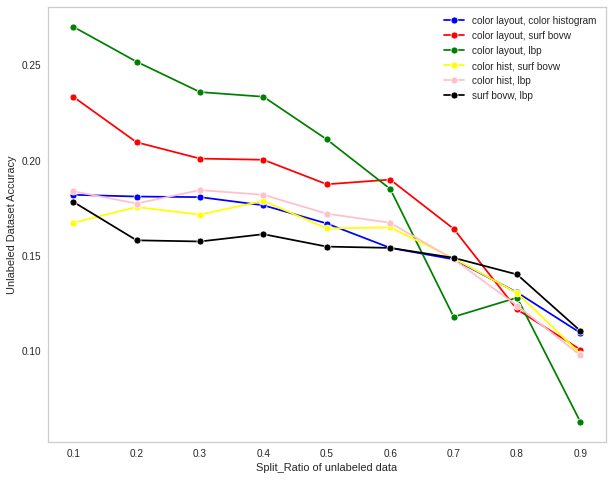

In [37]:
import seaborn as sns
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []

fifth_feature_splits = []
fifth_feat_acc = []
fifth_feature_lab_acc = []
fifth_feature_unlab_acc = []

sixth_feature_splits = []
sixth_feat_acc = []
sixth_feature_lab_acc = []
sixth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    fifth_feature_splits.append(split_ratio[i][4])
    fifth_feat_acc.append(total_data_acc[i][4])
    fifth_feature_lab_acc.append(labeled_data_acc[i][4])
    fifth_feature_unlab_acc.append(unlabeled_data_acc[i][4])
    
    sixth_feature_splits.append(split_ratio[i][5])
    sixth_feat_acc.append(total_data_acc[i][5])
    sixth_feature_lab_acc.append(labeled_data_acc[i][5])
    sixth_feature_unlab_acc.append(unlabeled_data_acc[i][5])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]
fifth_feature_splits = [i/10 for i in fifth_feature_splits]
sixth_feature_splits = [i/10 for i in sixth_feature_splits]

f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color layout, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="color layout, lbp", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="color hist, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =fifth_feature_splits, y= fifth_feature_unlab_acc, color="pink", marker="o", label="color hist, lbp", linestyle="-")
sns.lineplot(ax=ax, x =sixth_feature_splits, y= sixth_feature_unlab_acc, color="black", marker="o", label="surf bovw, lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of unlabeled data')
plt.ylabel('Unlabeled Dataset Accuracy')
plt.show()

In [38]:
"""
3 feature combination
"""

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

#labels_orig = labels
undersample = RandomUnderSampler(random_state=123)
fs = SelectKBest(score_func=f_classif, k=200)

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 3)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]], feat_list[feat_indx[2]]])
        fs.fit(temp_feat, labels_orig)
        temp_feat = fs.transform(temp_feat)
        
        exp_features, labels = undersample.fit_resample(temp_feat, labels_orig)
        
        #exp_features = temp_feat#np.exp(temp_feat)

        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")
        

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature (%d, %d, %d) index %f for %f of unlabled dataset"% (feat_indx[0],feat_indx[1],feat_indx[2], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabeled Dataset Accuracy: for feature (%d, %d, %d) index %f for %f of unlabled dataset"% (feat_indx[0],feat_indx[1],feat_indx[2], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labeled Dataset Accuracy: for feature (%d, %d, %d) index %f for %f of unlabled dataset"% (feat_indx[0],feat_indx[1],feat_indx[2], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 544, 200
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 200
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 1, 2) index 0.012132 for 90.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.109681 for 90.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.121324 for 90.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 544, 200
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 200
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 1, 3) index 0.011397 for 90.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.106413 for 90.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.113971 for 90.000000 of unlabled dataset
Labeled features set Size: 544, 200
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 200
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 2, 3) index 0.012500 for 90.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.065972 for 90.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.125000 for 90.000000 of unlabled dataset
Labeled features set Size: 544, 200
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 200
Unlabeled lable set Size: 4896



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 2, 3) index 0.012132 for 90.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.104984 for 90.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.121324 for 90.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1088, 200
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 200
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (0, 1, 2) index 0.028676 for 80.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.119026 for 80.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.143382 for 80.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1088, 200
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 200
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (0, 1, 3) index 0.028860 for 80.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.122472 for 80.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.144301 for 80.000000 of unlabled dataset
Labeled features set Size: 1088, 200
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 200
Unlabeled lable set Size: 4352

Dataset Accuracy: for feature (0, 2, 3) index 0.065809 for 80.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.160616 for 80.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.329044 for 80.000000 of unlabled dataset
Labeled features set Size: 1088, 200
Labeled lable set Size: 1088
Unlabeled features set Size: 4352, 200
Unlabeled lable set Size: 4352



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 2, 3) index 0.033824 for 80.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.133502 for 80.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.169118 for 80.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1632, 200
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 200
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (0, 1, 2) index 0.051654 for 70.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.152574 for 70.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.172181 for 70.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 1632, 200
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 200
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (0, 1, 3) index 0.051471 for 70.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.145746 for 70.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.171569 for 70.000000 of unlabled dataset
Labeled features set Size: 1632, 200
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 200
Unlabeled lable set Size: 3808

Dataset Accuracy: for feature (0, 2, 3) index 0.091912 for 70.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.170431 for 70.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.306373 for 70.000000 of unlabled dataset
Labeled features set Size: 1632, 200
Labeled lable set Size: 1632
Unlabeled features set Size: 3808, 200
Unlabeled lable set Size: 3808



/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Dataset Accuracy: for feature (1, 2, 3) index 0.055147 for 70.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.159401 for 70.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.183824 for 70.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2176, 200
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 200
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0, 1, 2) index 0.079044 for 60.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.166973 for 60.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.197610 for 60.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2176, 200
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 200
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0, 1, 3) index 0.075368 for 60.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.160233 for 60.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.188419 for 60.000000 of unlabled dataset
Labeled features set Size: 2176, 200
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 200
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0, 2, 3) index 0.120404 for 60.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.184436 for 60.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.301011 for 60.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2176, 200
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 200
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (1, 2, 3) index 0.082904 for 60.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.178922 for 60.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.207261 for 60.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2720, 200
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 200
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (0, 1, 2) index 0.106434 for 50.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.173897 for 50.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.212868 for 50.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2720, 200
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 200
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (0, 1, 3) index 0.099816 for 50.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.168015 for 50.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.199632 for 50.000000 of unlabled dataset
Labeled features set Size: 2720, 200
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 200
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (0, 2, 3) index 0.146875 for 50.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.190441 for 50.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.293750 for 50.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 2720, 200
Labeled lable set Size: 2720
Unlabeled features set Size: 2720, 200
Unlabeled lable set Size: 2720

Dataset Accuracy: for feature (1, 2, 3) index 0.109743 for 50.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.175368 for 50.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.219485 for 50.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3264, 200
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 200
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 1, 2) index 0.127757 for 40.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.193474 for 40.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.212929 for 40.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3264, 200
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 200
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 1, 3) index 0.121507 for 40.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.183824 for 40.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.202512 for 40.000000 of unlabled dataset
Labeled features set Size: 3264, 200
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 200
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 2, 3) index 0.173346 for 40.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.200368 for 40.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.288909 for 40.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3264, 200
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 200
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (1, 2, 3) index 0.127757 for 40.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.192096 for 40.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.212929 for 40.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3808, 200
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 200
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (0, 1, 2) index 0.154044 for 30.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.201593 for 30.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.220063 for 30.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3808, 200
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 200
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (0, 1, 3) index 0.146507 for 30.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.189338 for 30.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.209296 for 30.000000 of unlabled dataset
Labeled features set Size: 3808, 200
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 200
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (0, 2, 3) index 0.196507 for 30.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.200980 for 30.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.280725 for 30.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 3808, 200
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 200
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (1, 2, 3) index 0.152390 for 30.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.198529 for 30.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.217700 for 30.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4352, 200
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 200
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0, 1, 2) index 0.181801 for 20.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.195772 for 20.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.227252 for 20.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4352, 200
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 200
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0, 1, 3) index 0.171691 for 20.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.190257 for 20.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.214614 for 20.000000 of unlabled dataset
Labeled features set Size: 4352, 200
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 200
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0, 2, 3) index 0.218934 for 20.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.205882 for 20.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.273667 for 20.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4352, 200
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 200
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (1, 2, 3) index 0.180882 for 20.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (1, 2, 3) index 0.204963 for 20.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (1, 2, 3) index 0.226103 for 20.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4896, 200
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 200
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (0, 1, 2) index 0.210662 for 10.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 2) index 0.209559 for 10.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 2) index 0.234069 for 10.000000 of unlabled dataset


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Labeled features set Size: 4896, 200
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 200
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (0, 1, 3) index 0.199265 for 10.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 1, 3) index 0.196691 for 10.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 1, 3) index 0.221405 for 10.000000 of unlabled dataset
Labeled features set Size: 4896, 200
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 200
Unlabeled lable set Size: 544

Dataset Accuracy: for feature (0, 2, 3) index 0.239338 for 10.000000 of unlabled dataset
Unlabeled Dataset Accuracy: for feature (0, 2, 3) index 0.215074 for 10.000000 of unlabled dataset
Labeled Dataset Accuracy: for feature (0, 2, 3) index 0.265931 for 10.000000 of unlabled dataset
Labeled features set Size: 4896, 200
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 200
Unlabeled lable set Size: 544

Dataset Accuracy: for fea

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401
 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419
 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455
 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473
 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491
 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509
 510 511] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [39]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]

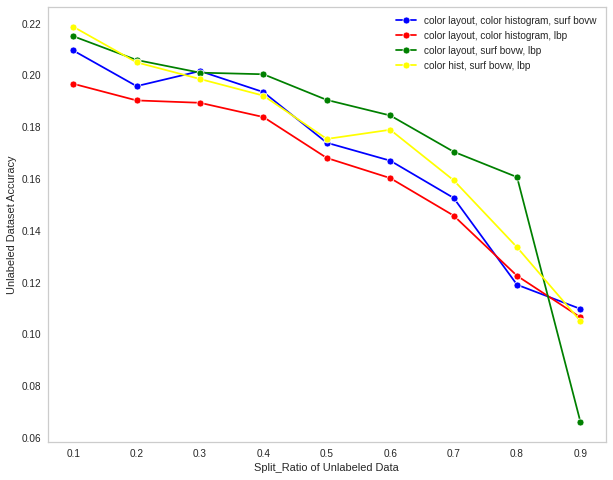

In [40]:
import seaborn as sns
f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color layout, color histogram, lbp", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="color layout, surf bovw, lbp", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="color hist, surf bovw, lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled Dataset Accuracy')
plt.show()

In [41]:
"""
based on the above curve chooising the most important features
"""

fs = SelectKBest(score_func=f_classif, k=200)
features = np.hstack([color_layout_features_scaled, bow_surf, np.array(hist)])

fs.fit(features, labels_orig)
features = fs.transform(features)

X_over, y_over = undersample.fit_resample(features, labels_orig)
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=0.1, random_state=1, stratify=y_over)

print("Labeled features set Size: %d, %d"%X_train_lab.shape)
print("Labeled lable set Size: %d"%y_train_lab.shape)
print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
print("")

X_train_mixed = concatenate((X_train_lab, X_test_unlab))
nolabel = [-1 for _ in range(len(y_test_unlab))]
y_train_mixed = concatenate((y_train_lab, nolabel))

model = MultinomialNBSS(verbose=False)

model.fit(X_train_mixed, y_train_mixed)

yhat = model.predict(X_train_mixed)
i = 0
print("Dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_train_mixed, yhat), i*10))

yhat = model.predict(X_train_mixed[y_train_mixed==-1])
print("Unlabeled dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_test_unlab, yhat), i*10))

yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
print("Labeled dataset Accuracy: %f for %f of Unlabeled dataset"% (accuracy_score(y_train_lab, yhat), i*10))

Labeled features set Size: 4896, 200
Labeled lable set Size: 4896
Unlabeled features set Size: 544, 200
Unlabeled lable set Size: 544

Dataset Accuracy: 0.239338 for 0.000000 of Unlabeled dataset
Unlabeled dataset Accuracy: 0.215074 for 0.000000 of Unlabeled dataset
Labeled dataset Accuracy: 0.265931 for 0.000000 of Unlabeled dataset


<AxesSubplot:>

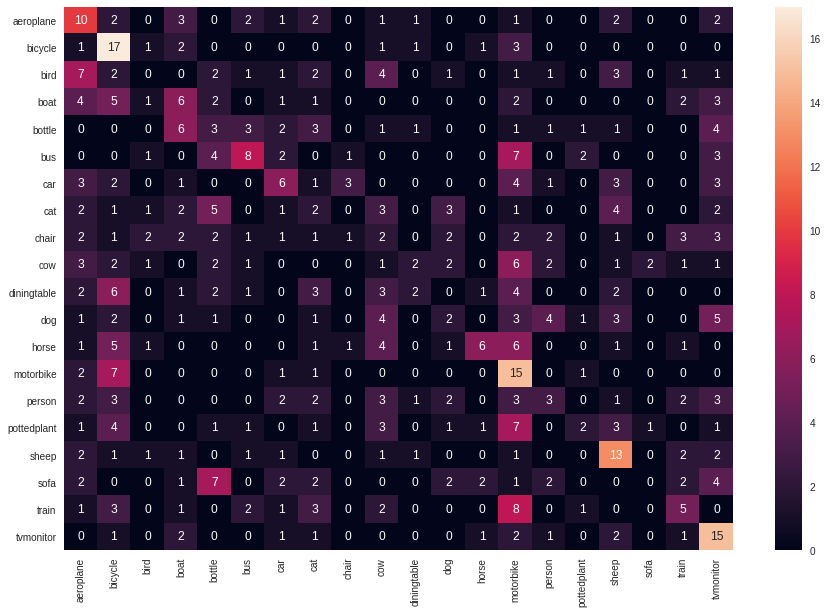

In [42]:
yhat = model.predict(X_train_mixed[y_train_mixed==-1])
conf_matrix = confusion_matrix(y_test_unlab, yhat)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classs = ['aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor']


df_cm = pd.DataFrame(conf_matrix, index = [i for i in classs],
                  columns = [i for i in classs])
df_cm = df_cm.astype(int)
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True, fmt="d")

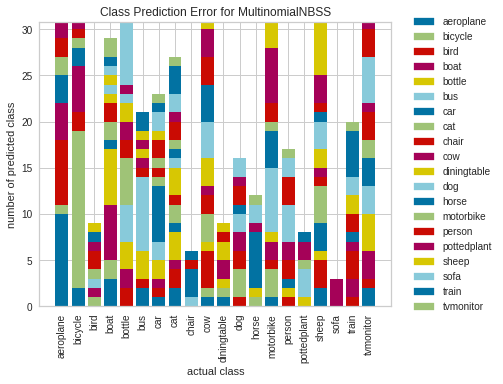

<AxesSubplot:title={'center':'Class Prediction Error for MultinomialNBSS'}, xlabel='actual class', ylabel='number of predicted class'>

In [43]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

visualizer = ClassPredictionError(MultinomialNBSS(verbose=False), classes=classs)
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

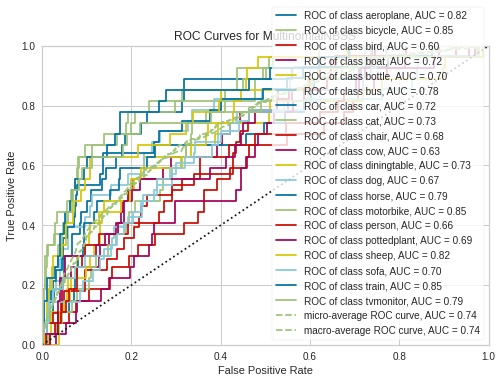

<AxesSubplot:title={'center':'ROC Curves for MultinomialNBSS'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [44]:
visualizer = ROCAUC(MultinomialNBSS(verbose=False), classes=classs)
visualizer.fit(X_train_mixed, y_train_mixed)
visualizer.score(X_train_mixed[y_train_mixed==-1], y_test_unlab)
visualizer.show()

In [45]:
from sklearn.metrics import classification_report
yhat = model.predict(X_train_mixed[y_train_mixed==-1])
print(classification_report(y_test_unlab, yhat, target_names=classs))

              precision    recall  f1-score   support

   aeroplane       0.22      0.37      0.27        27
     bicycle       0.27      0.63      0.37        27
        bird       0.00      0.00      0.00        27
        boat       0.21      0.22      0.21        27
      bottle       0.10      0.11      0.10        27
         bus       0.38      0.29      0.33        28
         car       0.26      0.22      0.24        27
         cat       0.07      0.07      0.07        27
       chair       0.17      0.04      0.06        28
         cow       0.03      0.04      0.03        27
 diningtable       0.22      0.07      0.11        27
         dog       0.12      0.07      0.09        28
       horse       0.50      0.21      0.30        28
   motorbike       0.19      0.56      0.29        27
      person       0.18      0.11      0.14        27
 pottedplant       0.25      0.07      0.11        27
       sheep       0.33      0.48      0.39        27
        sofa       0.00    

# Class Balancing with PCA

In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
"""
combination of 2 features
"""

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

undersample = RandomUnderSampler(random_state=123)
fs = SelectKBest(score_func=f_classif, k=100)
pca = PCA(n_components=5)

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 2)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]]])
        temp_feat = pca.fit_transform(temp_feat)
        temp_feat = MinMaxScaler().fit_transform(temp_feat)
        
        exp_features, labels = undersample.fit_resample(temp_feat, labels_orig)
        
        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled Dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabeled dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled Dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labeled dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled Dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

Labeled features set Size: 544, 5
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 5
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 1) index 0.006250 for 90.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 1) index 0.062500 for 90.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 1) index 0.062500 for 90.000000 of Unlabeled Dataset
Labeled features set Size: 544, 5
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 5
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 2) index 0.010110 for 90.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 2) index 0.087418 for 90.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 2) index 0.101103 for 90.000000 of Unlabeled Dataset
Labeled features set Size: 544, 5
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 5
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 3) index 0.0090

Labeled features set Size: 2176, 5
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 5
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (0, 3) index 0.053125 for 60.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 3) index 0.125613 for 60.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 3) index 0.132812 for 60.000000 of Unlabeled Dataset
Labeled features set Size: 2176, 5
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 5
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (1, 2) index 0.055331 for 60.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (1, 2) index 0.125919 for 60.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (1, 2) index 0.138327 for 60.000000 of Unlabeled Dataset
Labeled features set Size: 2176, 5
Labeled lable set Size: 2176
Unlabeled features set Size: 3264, 5
Unlabeled lable set Size: 3264

Dataset Accuracy: for feature (1, 3) index 

Labeled features set Size: 3808, 5
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 5
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (1, 3) index 0.088235 for 30.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (1, 3) index 0.123775 for 30.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (1, 3) index 0.126050 for 30.000000 of Unlabeled Dataset
Labeled features set Size: 3808, 5
Labeled lable set Size: 3808
Unlabeled features set Size: 1632, 5
Unlabeled lable set Size: 1632

Dataset Accuracy: for feature (2, 3) index 0.086213 for 30.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (2, 3) index 0.109069 for 30.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (2, 3) index 0.123162 for 30.000000 of Unlabeled Dataset
Labeled features set Size: 4352, 5
Labeled lable set Size: 4352
Unlabeled features set Size: 1088, 5
Unlabeled lable set Size: 1088

Dataset Accuracy: for feature (0, 1) index 

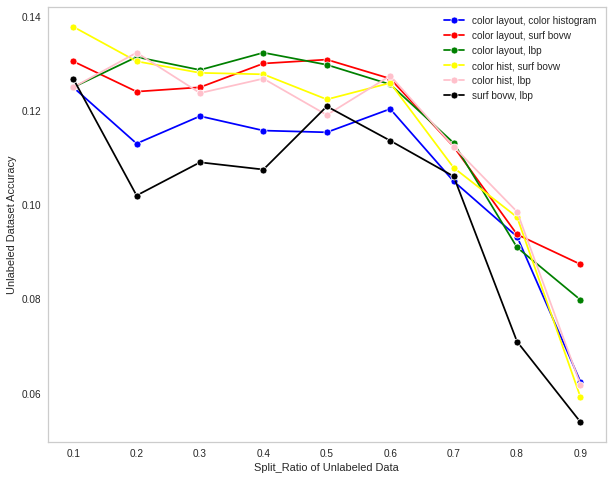

In [48]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []

fifth_feature_splits = []
fifth_feat_acc = []
fifth_feature_lab_acc = []
fifth_feature_unlab_acc = []

sixth_feature_splits = []
sixth_feat_acc = []
sixth_feature_lab_acc = []
sixth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    fifth_feature_splits.append(split_ratio[i][4])
    fifth_feat_acc.append(total_data_acc[i][4])
    fifth_feature_lab_acc.append(labeled_data_acc[i][4])
    fifth_feature_unlab_acc.append(unlabeled_data_acc[i][4])
    
    sixth_feature_splits.append(split_ratio[i][5])
    sixth_feat_acc.append(total_data_acc[i][5])
    sixth_feature_lab_acc.append(labeled_data_acc[i][5])
    sixth_feature_unlab_acc.append(unlabeled_data_acc[i][5])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]
fifth_feature_splits = [i/10 for i in fifth_feature_splits]
sixth_feature_splits = [i/10 for i in sixth_feature_splits]

f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color layout, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="color layout, lbp", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="color hist, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =fifth_feature_splits, y= fifth_feature_unlab_acc, color="pink", marker="o", label="color hist, lbp", linestyle="-")
sns.lineplot(ax=ax, x =sixth_feature_splits, y= sixth_feature_unlab_acc, color="black", marker="o", label="surf bovw, lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled Dataset Accuracy')
plt.show()

In [49]:
"""
3 feature combination
"""


total_data_acc = []
labeled_data_acc = []
unlabeled_data_acc = []
split_ratio = []

feat_list = [color_layout_features_scaled, color_hist_features, bow_surf, np.array(hist)]
stuff = [0, 1, 2, 3]

#labels_orig = labels
undersample = RandomUnderSampler(random_state=123)
fs = SelectKBest(score_func=f_classif, k=200)
pca = PCA(n_components=5)

for i in list(range(9, 0, -1)):
    
    feat_comb = [comb for comb in combinations(stuff, 3)]
    
    feature_split_ratio = []
    feature_comb_lst = []
    feature_comb_acc = []
    feature_comb_lab_acc = []
    feature_comb_unlab_acc = []
    
    for feat_indx in feat_comb:
        temp_feat = np.hstack([feat_list[feat_indx[0]], feat_list[feat_indx[1]], feat_list[feat_indx[2]]])
        temp_feat = pca.fit_transform(temp_feat)
        temp_feat = MinMaxScaler().fit_transform(temp_feat)
        
        exp_features, labels = undersample.fit_resample(temp_feat, labels_orig)
        
        tot_features = np.zeros((exp_features.shape[0], exp_features.shape[1]+1))
        tot_features[:,:-1] = exp_features
        tot_features[:,-1] = labels
        tot_features = tot_features[:, ~np.all(tot_features[1:] == tot_features[:-1], axis=0)]

        features = tot_features[:,:-1].astype("float64")
        lab = tot_features[:,-1].astype("uint8")
        
        X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(features, lab, test_size=i/10, random_state=1, stratify=lab)

        print("Labeled features set Size: %d, %d"%X_train_lab.shape)
        print("Labeled lable set Size: %d"%y_train_lab.shape)
        print("Unlabeled features set Size: %d, %d"%X_test_unlab.shape)
        print("Unlabeled lable set Size: %d"%y_test_unlab.shape)
        print("")

        X_train_mixed = concatenate((X_train_lab, X_test_unlab))
        nolabel = [-1 for _ in range(len(y_test_unlab))]
        y_train_mixed = concatenate((y_train_lab, nolabel))

        model = MultinomialNBSS(verbose=False)

        model.fit(X_train_mixed, y_train_mixed)

        yhat = model.predict(X_train_mixed)
        print("Dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled Dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_train_mixed, yhat), i*10))
        feature_comb_acc.append(yhat)
        
        yhat = model.predict(X_train_mixed[y_train_mixed==-1])
        print("Unlabeled dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled Dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_test_unlab, yhat), i*10))
        feature_comb_unlab_acc.append(accuracy_score(y_test_unlab, yhat))
        
        yhat = model.predict(X_train_mixed[y_train_mixed!=-1])
        print("Labeled dataset Accuracy: for feature (%d, %d) index %f for %f of Unlabeled Dataset"% (feat_indx[0],feat_indx[1], accuracy_score(y_train_lab, yhat), i*10))
        feature_comb_lab_acc.append(accuracy_score(y_train_lab, yhat))
        
        feature_split_ratio.append(i)
        feature_comb_lst.append(feat_indx)
        
        
    total_data_acc.append(feature_comb_acc)
    labeled_data_acc.append(feature_comb_lab_acc)
    unlabeled_data_acc.append(feature_comb_unlab_acc)
    split_ratio.append(feature_split_ratio)

Labeled features set Size: 544, 5
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 5
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 1) index 0.006250 for 90.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 1) index 0.062296 for 90.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 1) index 0.062500 for 90.000000 of Unlabeled Dataset
Labeled features set Size: 544, 5
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 5
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 1) index 0.006250 for 90.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 1) index 0.061683 for 90.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 1) index 0.062500 for 90.000000 of Unlabeled Dataset
Labeled features set Size: 544, 5
Labeled lable set Size: 544
Unlabeled features set Size: 4896, 5
Unlabeled lable set Size: 4896

Dataset Accuracy: for feature (0, 2) index 0.0101

Labeled features set Size: 3264, 5
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 5
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 1) index 0.077390 for 40.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 1) index 0.117647 for 40.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 1) index 0.128983 for 40.000000 of Unlabeled Dataset
Labeled features set Size: 3264, 5
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 5
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 1) index 0.077390 for 40.000000 of Unlabeled Dataset
Unlabeled dataset Accuracy: for feature (0, 1) index 0.113971 for 40.000000 of Unlabeled Dataset
Labeled dataset Accuracy: for feature (0, 1) index 0.128983 for 40.000000 of Unlabeled Dataset
Labeled features set Size: 3264, 5
Labeled lable set Size: 3264
Unlabeled features set Size: 2176, 5
Unlabeled lable set Size: 2176

Dataset Accuracy: for feature (0, 2) index 

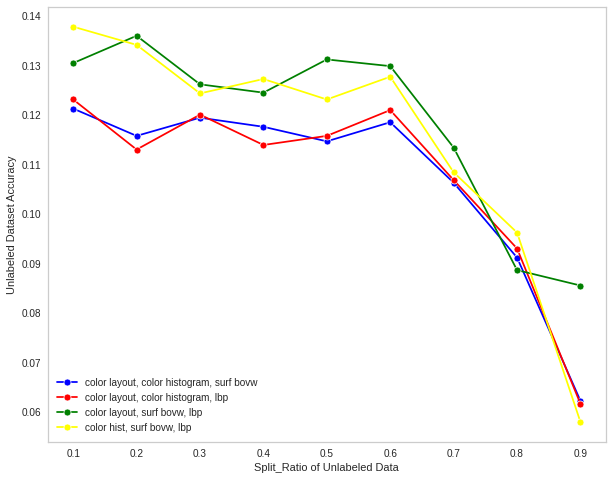

In [50]:
first_feature_splits = []
first_feat_acc = []
first_feature_lab_acc = []
first_feature_unlab_acc = []

sec_feature_splits = []
sec_feat_acc = []
sec_feature_lab_acc = []
sec_feature_unlab_acc = []

third_feature_splits = []
third_feat_acc = []
third_feature_lab_acc = []
third_feature_unlab_acc = []

fourth_feature_splits = []
fourth_feat_acc = []
fourth_feature_lab_acc = []
fourth_feature_unlab_acc = []


for i in range(9):
    first_feature_splits.append(split_ratio[i][0])
    first_feat_acc.append(total_data_acc[i][0])
    first_feature_lab_acc.append(labeled_data_acc[i][0])
    first_feature_unlab_acc.append(unlabeled_data_acc[i][0])
    
    sec_feature_splits.append(split_ratio[i][1])
    sec_feat_acc.append(total_data_acc[i][1])
    sec_feature_lab_acc.append(labeled_data_acc[i][1])
    sec_feature_unlab_acc.append(unlabeled_data_acc[i][1])
    
    third_feature_splits.append(split_ratio[i][2])
    third_feat_acc.append(total_data_acc[i][2])
    third_feature_lab_acc.append(labeled_data_acc[i][2])
    third_feature_unlab_acc.append(unlabeled_data_acc[i][2])
    
    fourth_feature_splits.append(split_ratio[i][3])
    fourth_feat_acc.append(total_data_acc[i][3])
    fourth_feature_lab_acc.append(labeled_data_acc[i][3])
    fourth_feature_unlab_acc.append(unlabeled_data_acc[i][3])
    
    
first_feature_splits = [i/10 for i in first_feature_splits]
sec_feature_splits = [i/10 for i in sec_feature_splits]
third_feature_splits = [i/10 for i in third_feature_splits]
fourth_feature_splits = [i/10 for i in fourth_feature_splits]

import seaborn as sns
f, ax = plt.subplots(1, 1,figsize=(10,8))
sns.lineplot(ax=ax, x =first_feature_splits, y= first_feature_unlab_acc, color="blue", marker="o", label="color layout, color histogram, surf bovw", linestyle="-")
sns.lineplot(ax=ax, x =sec_feature_splits, y= sec_feature_unlab_acc, color="red", marker="o", label="color layout, color histogram, lbp", linestyle="-")
sns.lineplot(ax=ax, x =third_feature_splits, y= third_feature_unlab_acc, color="green", marker="o", label="color layout, surf bovw, lbp", linestyle="-")
sns.lineplot(ax=ax, x =fourth_feature_splits, y= fourth_feature_unlab_acc, color="yellow", marker="o", label="color hist, surf bovw, lbp", linestyle="-")

ax.legend()
plt.grid()
plt.xlabel('Split_Ratio of Unlabeled Data')
plt.ylabel('Unlabeled Dataset Accuracy')
plt.show()

In [51]:
# Box Plot
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

In [52]:
result_matrix = np.zeros((9, 3))
fs = SelectKBest(score_func=f_classif, k=200)
undersample = RandomUnderSampler(random_state=123)
pca = PCA(n_components=5)

for i in list(range(9, 0, -1)):
    
    features = np.hstack([color_hist_features, np.array(hist)])
    X_over, y_over = undersample.fit_resample(features, labels_orig)
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=i/10, random_state=1, stratify=y_over)

    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    result_matrix[i-1,0] = accuracy_score(y_test_unlab, yhat)

    features = np.hstack([color_layout_features_scaled, color_hist_features])
    fs.fit(features, labels_orig)
    features = fs.transform(features)

    X_over, y_over = undersample.fit_resample(features, labels_orig)
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=i/10, random_state=1, stratify=y_over)

    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    result_matrix[i-1,1] = accuracy_score(y_test_unlab, yhat)
    
    features = np.hstack([color_layout_features_scaled, bow_surf, np.array(hist)])
    temp_feat = pca.fit_transform(features)

    X_over, y_over = undersample.fit_resample(features, labels_orig)
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=i/10, random_state=1, stratify=y_over)

    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    result_matrix[i-1,2] = accuracy_score(y_test_unlab, yhat)

/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/sklear

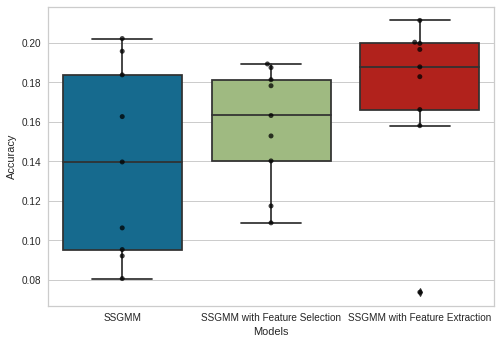

In [53]:
df = pd.DataFrame()
df['Accuracy'] = result_matrix[:,0]
df['Models'] = "SSGMM"

df1 = pd.DataFrame()
df1['Accuracy'] = result_matrix[:,1]
df1['Models'] = "SSGMM with Feature Selection"

df2 = pd.DataFrame()
df2['Accuracy'] = result_matrix[:,2]
df2['Models'] = "SSGMM with Feature Extraction"

df = df.append(df1)
df = df.append(df2)


ax = sns.boxplot(x="Models", y="Accuracy", data=df)
ax = sns.swarmplot(x="Models", y="Accuracy", data=df, color='black', alpha=0.75)


plt.show()

# Confidence Interval

In [54]:
from imblearn.under_sampling import RandomUnderSampler

In [74]:
# without any feature selection

undersample = RandomUnderSampler()

accuracy = []

for i in range(70):
    print(i)
    features = np.hstack([color_hist_features, bow_surf])

    X_over, y_over = undersample.fit_resample(features, labels_orig)
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=1/10, stratify=y_over)

    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    accuracy.append(accuracy_score(y_test_unlab, yhat))
    print(accuracy)

0
[0.19852941176470587]
1
[0.19852941176470587, 0.2647058823529412]
2
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646]
3
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059]
4
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764]
5
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705]
6
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823]
7
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823]
8
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25]
9
[0.19852941176470587, 0.2647058823529412, 0.20588235294

[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25, 0.20220588235294118, 0.22426470588235295, 0.21507352941176472, 0.20220588235294118, 0.22977941176470587, 0.26286764705882354, 0.25183823529411764, 0.24448529411764705, 0.18382352941176472, 0.24632352941176472, 0.23897058823529413, 0.2536764705882353, 0.22058823529411764, 0.20404411764705882, 0.25, 0.22242647058823528, 0.21875, 0.22977941176470587, 0.21507352941176472, 0.22058823529411764, 0.20955882352941177]
30
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25, 0.20220588235294118, 0.22426470588235295, 0.21507352941176472, 0.20220588235294118, 0.22977941176470587, 0.26286764705882354, 0.25183823529411764, 0.24448529411764705, 0.18382352941176472, 0.24632352941176472, 0.23897058823529413, 0.25367

[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25, 0.20220588235294118, 0.22426470588235295, 0.21507352941176472, 0.20220588235294118, 0.22977941176470587, 0.26286764705882354, 0.25183823529411764, 0.24448529411764705, 0.18382352941176472, 0.24632352941176472, 0.23897058823529413, 0.2536764705882353, 0.22058823529411764, 0.20404411764705882, 0.25, 0.22242647058823528, 0.21875, 0.22977941176470587, 0.21507352941176472, 0.22058823529411764, 0.20955882352941177, 0.23897058823529413, 0.24448529411764705, 0.20036764705882354, 0.21691176470588236, 0.28308823529411764, 0.22426470588235295, 0.2426470588235294, 0.2113970588235294, 0.2536764705882353, 0.21691176470588236, 0.20036764705882354, 0.23897058823529413]
42
[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058

[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25, 0.20220588235294118, 0.22426470588235295, 0.21507352941176472, 0.20220588235294118, 0.22977941176470587, 0.26286764705882354, 0.25183823529411764, 0.24448529411764705, 0.18382352941176472, 0.24632352941176472, 0.23897058823529413, 0.2536764705882353, 0.22058823529411764, 0.20404411764705882, 0.25, 0.22242647058823528, 0.21875, 0.22977941176470587, 0.21507352941176472, 0.22058823529411764, 0.20955882352941177, 0.23897058823529413, 0.24448529411764705, 0.20036764705882354, 0.21691176470588236, 0.28308823529411764, 0.22426470588235295, 0.2426470588235294, 0.2113970588235294, 0.2536764705882353, 0.21691176470588236, 0.20036764705882354, 0.23897058823529413, 0.21507352941176472, 0.24448529411764705, 0.2665441176470588, 0.2647058823529412, 0.23161764705882354, 0.21875, 0.20955882352941177, 0.20772058823529413, 0.21875]
51

[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25, 0.20220588235294118, 0.22426470588235295, 0.21507352941176472, 0.20220588235294118, 0.22977941176470587, 0.26286764705882354, 0.25183823529411764, 0.24448529411764705, 0.18382352941176472, 0.24632352941176472, 0.23897058823529413, 0.2536764705882353, 0.22058823529411764, 0.20404411764705882, 0.25, 0.22242647058823528, 0.21875, 0.22977941176470587, 0.21507352941176472, 0.22058823529411764, 0.20955882352941177, 0.23897058823529413, 0.24448529411764705, 0.20036764705882354, 0.21691176470588236, 0.28308823529411764, 0.22426470588235295, 0.2426470588235294, 0.2113970588235294, 0.2536764705882353, 0.21691176470588236, 0.20036764705882354, 0.23897058823529413, 0.21507352941176472, 0.24448529411764705, 0.2665441176470588, 0.2647058823529412, 0.23161764705882354, 0.21875, 0.20955882352941177, 0.20772058823529413, 0.21875, 0.

[0.19852941176470587, 0.2647058823529412, 0.20588235294117646, 0.2610294117647059, 0.22058823529411764, 0.24448529411764705, 0.22794117647058823, 0.22794117647058823, 0.25, 0.20220588235294118, 0.22426470588235295, 0.21507352941176472, 0.20220588235294118, 0.22977941176470587, 0.26286764705882354, 0.25183823529411764, 0.24448529411764705, 0.18382352941176472, 0.24632352941176472, 0.23897058823529413, 0.2536764705882353, 0.22058823529411764, 0.20404411764705882, 0.25, 0.22242647058823528, 0.21875, 0.22977941176470587, 0.21507352941176472, 0.22058823529411764, 0.20955882352941177, 0.23897058823529413, 0.24448529411764705, 0.20036764705882354, 0.21691176470588236, 0.28308823529411764, 0.22426470588235295, 0.2426470588235294, 0.2113970588235294, 0.2536764705882353, 0.21691176470588236, 0.20036764705882354, 0.23897058823529413, 0.21507352941176472, 0.24448529411764705, 0.2665441176470588, 0.2647058823529412, 0.23161764705882354, 0.21875, 0.20955882352941177, 0.20772058823529413, 0.21875, 0.

2.5th percentile = 0.200
97.5th percentile = 0.265


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


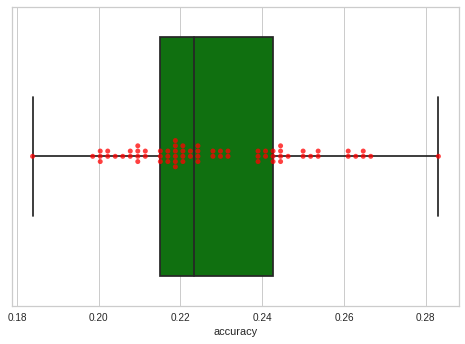

In [75]:
alpha = 5.0
scores = accuracy

lower_p = alpha / 2.0

lower = max(0.0, np.percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))

upper_p = (100 - alpha) + (alpha / 2.0)

upper = min(1.0, np.percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))

import seaborn as sns
plt.xlabel("accuracy")
ax = sns.boxplot(accuracy, color='green')
ax = sns.swarmplot(accuracy, alpha=0.75, color='red')

In [76]:
np.mean(accuracy) - 0.200

0.02799369747899158

In [77]:
np.mean(accuracy)

0.2279936974789916

In [ ]:
0.228 +- 0.0280

In [70]:
# with Anova feature selection

result_matrix = np.zeros((9, 3))
fs = SelectKBest(score_func=f_classif, k=200)
undersample = RandomUnderSampler()
pca = PCA(n_components=5)

accuracy = []

for i in range(100):
    features = np.hstack([color_layout_features_scaled, bow_surf, np.array(hist)])
    fs.fit(features, labels_orig)
    features = fs.transform(features)

    X_over, y_over = undersample.fit_resample(features, labels_orig)
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=1/10, stratify=y_over)

    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    accuracy.append(accuracy_score(y_test_unlab, yhat))
    print(accuracy)

[0.20772058823529413]
[0.20772058823529413, 0.20955882352941177]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236]
[0.20772058823529413, 0.20955882352941177, 0.1966911

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.1966911

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528]
[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118,

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

[0.20772058823529413, 0.20955882352941177, 0.19669117647058823, 0.1948529411764706, 0.21323529411764705, 0.19669117647058823, 0.20220588235294118, 0.18566176470588236, 0.21691176470588236, 0.19669117647058823, 0.21323529411764705, 0.2113970588235294, 0.20036764705882354, 0.19117647058823528, 0.18566176470588236, 0.1801470588235294, 0.21691176470588236, 0.19852941176470587, 0.19669117647058823, 0.18382352941176472, 0.21323529411764705, 0.19117647058823528, 0.22977941176470587, 0.21875, 0.20404411764705882, 0.20955882352941177, 0.19669117647058823, 0.20955882352941177, 0.1948529411764706, 0.20588235294117646, 0.21875, 0.20955882352941177, 0.19852941176470587, 0.21323529411764705, 0.20404411764705882, 0.20404411764705882, 0.1948529411764706, 0.20772058823529413, 0.17830882352941177, 0.20588235294117646, 0.22977941176470587, 0.22242647058823528, 0.21507352941176472, 0.20772058823529413, 0.19301470588235295, 0.2261029411764706, 0.17279411764705882, 0.20772058823529413, 0.20955882352941177, 

2.5th percentile = 0.182
97.5th percentile = 0.231


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


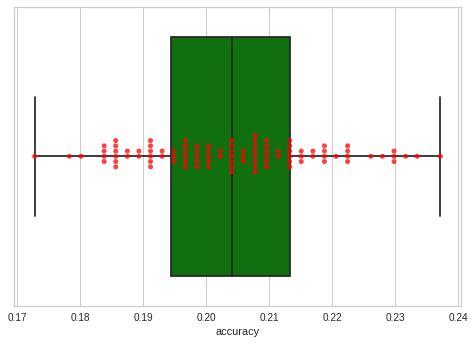

In [71]:
alpha = 5.0
scores = accuracy

lower_p = alpha / 2.0

lower = max(0.0, np.percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))

upper_p = (100 - alpha) + (alpha / 2.0)

upper = min(1.0, np.percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))

import seaborn as sns
plt.xlabel("accuracy")
ax = sns.boxplot(accuracy, color='green')
ax = sns.swarmplot(accuracy, alpha=0.75, color='red')

In [72]:
np.mean(accuracy) - 0.182

0.022080882352941117

In [73]:
np.mean(accuracy)

0.2040808823529411

In [ ]:
0.204 +- 0.022

In [66]:
"""
with pca
"""
from sklearn.decomposition import PCA

pca = PCA(n_components=5)


accuracy = []

for i in range(70):
    
    features = np.hstack([color_layout_features_scaled, bow_surf, np.array(hist)])
    temp_feat = pca.fit_transform(features)

    X_over, y_over = undersample.fit_resample(features, labels_orig)
    X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_over, y_over, test_size=1/10, stratify=y_over)

    X_train_mixed = concatenate((X_train_lab, X_test_unlab))
    nolabel = [-1 for _ in range(len(y_test_unlab))]
    y_train_mixed = concatenate((y_train_lab, nolabel))

    model = MultinomialNBSS(verbose=False)
    model.fit(X_train_mixed, y_train_mixed)

    yhat = model.predict(X_train_mixed[y_train_mixed==-1])
    accuracy.append(accuracy_score(y_test_unlab, yhat))
    print(accuracy)

[0.22058823529411764]
[0.22058823529411764, 0.20588235294117646]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587]
[0.22058823529411764, 0.20588235294117646, 0.2022

[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587, 0.20772058823529413, 0.19669117647058823, 0.2261029411764706, 0.20404411764705882, 0.2113970588235294, 0.19669117647058823, 0.20588235294117646, 0.20036764705882354, 0.20404411764705882, 0.20955882352941177, 0.1948529411764706, 0.18933823529411764, 0.21691176470588236, 0.19669117647058823, 0.18198529411764705, 0.18566176470588236, 0.1875, 0.22977941176470587, 0.17647058823529413, 0.21323529411764705]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587, 0.20772058823529413, 0.19669117647058823, 0.2261029411764706, 0.20404411764705882, 0.2113970588235294, 0.19669117647058823, 0.20588235294117646, 0.20036764705882354, 0.20404411764705882, 0.20955882352941177, 0.19485294

[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587, 0.20772058823529413, 0.19669117647058823, 0.2261029411764706, 0.20404411764705882, 0.2113970588235294, 0.19669117647058823, 0.20588235294117646, 0.20036764705882354, 0.20404411764705882, 0.20955882352941177, 0.1948529411764706, 0.18933823529411764, 0.21691176470588236, 0.19669117647058823, 0.18198529411764705, 0.18566176470588236, 0.1875, 0.22977941176470587, 0.17647058823529413, 0.21323529411764705, 0.20036764705882354, 0.19301470588235295, 0.2113970588235294, 0.23345588235294118, 0.19117647058823528, 0.22426470588235295, 0.18933823529411764, 0.20588235294117646, 0.17463235294117646, 0.21507352941176472, 0.2113970588235294, 0.20036764705882354]
[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176

[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587, 0.20772058823529413, 0.19669117647058823, 0.2261029411764706, 0.20404411764705882, 0.2113970588235294, 0.19669117647058823, 0.20588235294117646, 0.20036764705882354, 0.20404411764705882, 0.20955882352941177, 0.1948529411764706, 0.18933823529411764, 0.21691176470588236, 0.19669117647058823, 0.18198529411764705, 0.18566176470588236, 0.1875, 0.22977941176470587, 0.17647058823529413, 0.21323529411764705, 0.20036764705882354, 0.19301470588235295, 0.2113970588235294, 0.23345588235294118, 0.19117647058823528, 0.22426470588235295, 0.18933823529411764, 0.20588235294117646, 0.17463235294117646, 0.21507352941176472, 0.2113970588235294, 0.20036764705882354, 0.21507352941176472, 0.20955882352941177, 0.18198529411764705, 0.2113970588235294, 0.18933823529411764, 0.22058823529411764, 0.21691176470588236, 0.207720588

[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587, 0.20772058823529413, 0.19669117647058823, 0.2261029411764706, 0.20404411764705882, 0.2113970588235294, 0.19669117647058823, 0.20588235294117646, 0.20036764705882354, 0.20404411764705882, 0.20955882352941177, 0.1948529411764706, 0.18933823529411764, 0.21691176470588236, 0.19669117647058823, 0.18198529411764705, 0.18566176470588236, 0.1875, 0.22977941176470587, 0.17647058823529413, 0.21323529411764705, 0.20036764705882354, 0.19301470588235295, 0.2113970588235294, 0.23345588235294118, 0.19117647058823528, 0.22426470588235295, 0.18933823529411764, 0.20588235294117646, 0.17463235294117646, 0.21507352941176472, 0.2113970588235294, 0.20036764705882354, 0.21507352941176472, 0.20955882352941177, 0.18198529411764705, 0.2113970588235294, 0.18933823529411764, 0.22058823529411764, 0.21691176470588236, 0.207720588

[0.22058823529411764, 0.20588235294117646, 0.20220588235294118, 0.17279411764705882, 0.19301470588235295, 0.22794117647058823, 0.2113970588235294, 0.21691176470588236, 0.19852941176470587, 0.20772058823529413, 0.19669117647058823, 0.2261029411764706, 0.20404411764705882, 0.2113970588235294, 0.19669117647058823, 0.20588235294117646, 0.20036764705882354, 0.20404411764705882, 0.20955882352941177, 0.1948529411764706, 0.18933823529411764, 0.21691176470588236, 0.19669117647058823, 0.18198529411764705, 0.18566176470588236, 0.1875, 0.22977941176470587, 0.17647058823529413, 0.21323529411764705, 0.20036764705882354, 0.19301470588235295, 0.2113970588235294, 0.23345588235294118, 0.19117647058823528, 0.22426470588235295, 0.18933823529411764, 0.20588235294117646, 0.17463235294117646, 0.21507352941176472, 0.2113970588235294, 0.20036764705882354, 0.21507352941176472, 0.20955882352941177, 0.18198529411764705, 0.2113970588235294, 0.18933823529411764, 0.22058823529411764, 0.21691176470588236, 0.207720588

2.5th percentile = 0.176
97.5th percentile = 0.233


/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/s9chroma/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


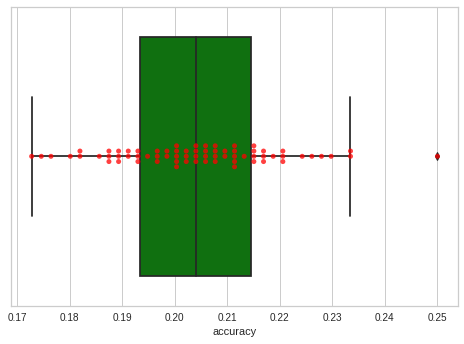

In [67]:
alpha = 5.0
scores = accuracy

lower_p = alpha / 2.0

lower = max(0.0, np.percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))

upper_p = (100 - alpha) + (alpha / 2.0)

upper = min(1.0, np.percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))

import seaborn as sns
plt.xlabel("accuracy")
ax = sns.boxplot(accuracy, color='green')
ax = sns.swarmplot(accuracy, alpha=0.75, color='red')

In [68]:
np.mean(accuracy) - 0.176

0.028464285714285747

In [69]:
np.mean(accuracy)

0.20446428571428574

In [ ]:
0.204 +- 0.176